In [4]:
import numpy as np
import read_wl_data as rdwl

In [7]:
loaded_dataset = None

In [5]:
Dataset = 'Vechtstromen'
timestamp = '01/03/2023 15:00:00'
norm_x = True
norm_y = True
norm_z = True
nb_intermediate_values_grid = 100
nb_intermediate_values_grid_for_mask_tests = 0
Kernel_name = 'Matern 1.5'
parameters_optimization = True
bounds_constant_value = np.logspace(-1, 1, 10)
bounds_length_scale = np.logspace(-1, 1, 10)
masking_bounds = [0.2*(1+a) for a in range(4)]
number_of_tests = 50
confidence = 0.95

## Data extraction

### Dataset loading

In [ ]:
dict_sensors_datas,loaded_dataset = rdwl.read_dataset(Dataset,loaded_dataset=loaded_dataset)

### Creation of a dataset for a particular time t

In [53]:
def same_hour(time1,time2):
    day_hour1 = time1.split(sep=':')[0]
    day_hour2 = time2.split(sep=':')[0]
    return day_hour1==day_hour2
    
def hour_in_keys(time1,set_of_times):
    a = False,0
    for time2 in set_of_times:
        if same_hour(time1,time2):
            a= True,time2
            break
    return a

def sensors_value_at_timestamp(time,dict_sensors):
    dict_values_at_time = {}
    for key in dict_sensors.keys():
        value_per_hour_sensor = dict_sensors[key]["data_per_hour"]
        exist,value_time = hour_in_keys(time,value_per_hour_sensor.keys()) # Finds other measures made within the same hour 
        if exist :
            dict_values_at_time[key] = value_per_hour_sensor[value_time]
            dict_values_at_time[key]['x']= dict_sensors[key]['location_rd_x']
            dict_values_at_time[key]['y']= dict_sensors[key]['location_rd_y']
    return dict_values_at_time        

### Representation of the sensors and their values at the time t

In [54]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [55]:

def sensors_values_to_matrix(time,dict_sensors):
    dict_sensors_at_timestamp = rdwl.sensors_value_at_timestamp(time,dict_sensors)
    Y = np.array([dict_sensors_at_timestamp[key]['y'] for key in dict_sensors_at_timestamp.keys()])
    y_mean,y_std = np.mean(Y),np.std(Y)
    Y = (Y-y_mean)/y_std
    X = np.array([dict_sensors_at_timestamp[key]['x'] for key in dict_sensors_at_timestamp.keys()])
    x_mean,x_std = np.mean(X),np.std(X)
    X = (X-x_mean)/x_std
    # Z_val = np.log(np.log(np.array([dict_sensors_at_timestamp[key]['avg'] for key in dict_sensors_at_timestamp.keys()])))
    # Z_val = np.log(np.array([dict_sensors_at_timestamp[key]['avg'] for key in dict_sensors_at_timestamp.keys()]))
    Z_val = np.array([dict_sensors_at_timestamp[key]['avg'] for key in dict_sensors_at_timestamp.keys()])
    z_mean = np.mean(Z_val)
    z_std = np.std(Z_val)
    Z_val = (Z_val-z_mean)/z_std
    Z_min = (np.array([dict_sensors_at_timestamp[key]['min'] for key in dict_sensors_at_timestamp.keys()])-z_mean)/z_std
    Z_max = (np.array([dict_sensors_at_timestamp[key]['max'] for key in dict_sensors_at_timestamp.keys()])-z_mean)/z_std
    Z_err = np.vstack((Z_val - Z_min, Z_max - Z_val))
    return {'x':X,'y':Y,'z':Z_val,'min':Z_min,'max':Z_max,'err':Z_err,'z_mean':z_mean,'z_std':z_std,'x_mean':x_mean,'x_std':x_std,'y_mean':y_mean,'y_std':y_std}


In [56]:
    
# dict_matrix_values = sensors_values_to_matrix(timestamp,dict_sensors_datas)

In [57]:

def plot_sensors_values_3D(dict_matrix_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Tracer les points avec des barres d'erreur
    ax.errorbar(dict_matrix_data['x'], dict_matrix_data['y'], dict_matrix_data['z'],xerr=np.zeros(dict_matrix_data['x'].shape),yerr=np.zeros(dict_matrix_data['y'].shape), zerr=dict_matrix_data['err'], fmt='o', capsize=5)

    # Ajouter des étiquettes aux axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [58]:
# plot_sensors_values_3D(dict_matrix_values)

## GPR

In [59]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF,ConstantKernel


### Data reshape for gaussian processing

In [60]:
def create_grid_matrix_XY(val_x,val_y,nb_intermediate_val):
    # creates a 2D grid on which we'll predict the Z values with GPR
    min_x,max_x = np.min(val_x),np.max(val_x)
    delta_x = max_x - min_x
    min_y,max_y = np.min(val_y),np.max(val_y)
    delta_y = max_y - min_y
    new_x = np.sort(np.concatenate((np.linspace(min_x-0.1*delta_x,max_x+0.1*delta_x,nb_intermediate_val),val_x))) # we add the values we know
    new_y = np.sort(np.concatenate((np.linspace(min_y-0.1*delta_y,max_y+0.1*delta_y,nb_intermediate_val),val_y)))
    new_x, new_y = np.meshgrid(new_x, new_y)
    return new_x,new_y

def create_grid_matrix_A(val_x,val_y,nb_intermediate_val):
    new_x, new_y = create_grid_matrix_XY(val_x,val_y,nb_intermediate_val)
    return np.column_stack((new_x.flatten(),new_y.flatten()))

In [61]:
# A_train = np.column_stack((dict_matrix_values['x'], dict_matrix_values['y']))
# A = create_grid_matrix_A(dict_matrix_values['x'], dict_matrix_values['y'],100)
# X,Y = create_grid_matrix_XY(dict_matrix_values['x'], dict_matrix_values['y'],100)
# Z_train = dict_matrix_values['z']

In [62]:
# nb_sensors = len(dict_matrix_values['x'])
# nb_val_per_axis = len(X[:,0])
# print(nb_sensors)

### Parameters Optmisation

In [63]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import GridSearchCV


In [64]:
def matern_kernel(constant_value,length_scale,nu):
    return ConstantKernel(constant_value=constant_value)*Matern(length_scale=length_scale,nu = nu)

def create_kernel_dict(constant_value,length_scale):
    kernel_dict = {"Matern 0.5":matern_kernel(constant_value,length_scale,0.5),"Matern 1.5":matern_kernel(constant_value,length_scale,1.5),"Matern 2.5":matern_kernel(constant_value,length_scale,2.5),"RBF":Matern(length_scale=1, length_scale_bounds=(1e-2, 1e2))}
    return kernel_dict

In [65]:
### Kernel attribution

# kernel_dict = create_kernel_dict(1,1)

# kernel = kernel_dict[Kernel_name]

In [66]:
# if parameters_optimization:
#     model = GaussianProcessRegressor(kernel=kernel)

#     # defining parameters to optimize
#     param_grid = {
#         'kernel__k1__constant_value': bounds_constant_value,  # Amplitude
#         'kernel__k2__length_scale': bounds_length_scale,     # correlation length
#     }

#     # Research of best parameters with cross validation
#     grid_search = GridSearchCV(model, param_grid, cv=5)
#     grid_search.fit(A_train, Z_train)

#     # best parameters within indicated bounds
#     best_params = grid_search.best_params_
# else :
#     default_parameters = {'kernel__k1__constant_value': 0.6, 'kernel__k2__length_scale': 0.2}
#     best_params = default_parameters

In [67]:
# kernel = create_kernel_dict(best_params['kernel__k1__constant_value'],best_params['kernel__k2__length_scale'])[Kernel_name]
# model = GaussianProcessRegressor(kernel=kernel)

# model.fit(A_train, Z_train)

# print(best_params)

### Results

In [68]:
# mean_prediction, std_prediction = model.predict(A, return_std=True)

#### Un-normalized values

In [69]:
# real_mean_pred = mean_prediction*dict_matrix_values['z_std']+dict_matrix_values['z_mean']
# real_std_pred = std_prediction*dict_matrix_values['z_std']
# real_A = np.column_stack((A[:,0]*dict_matrix_values['x_std']+dict_matrix_values['x_mean'],A[:,1]*dict_matrix_values['y_std']+dict_matrix_values['y_mean']))
# real_X_grid = X*dict_matrix_values['x_std']+dict_matrix_values['x_mean']
# real_Y_grid = Y*dict_matrix_values['y_std']+dict_matrix_values['y_mean']
# real_A_train = np.column_stack((A_train[:,0]*dict_matrix_values['x_std']+dict_matrix_values['x_mean'],A_train[:,1]*dict_matrix_values['y_std']+dict_matrix_values['y_mean']))
# real_Z_train = Z_train*dict_matrix_values['z_std']+dict_matrix_values['z_mean']

### Results plotting

In [70]:
def plot_3D_regression(X_grid,Y_grid,Z,title=None):
    if title is None :
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(X_grid,Y_grid,Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
    else:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(X_grid,Y_grid,Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title(title)
        plt.show()


In [71]:

# plot_3D_regression(X,Y,mean_prediction.reshape(nb_val_per_axis,nb_val_per_axis),title="Normalized Mean Prediction")

# plot_3D_regression(real_X_grid,real_Y_grid, real_mean_pred.reshape(nb_val_per_axis,nb_val_per_axis),title="Mean Prediction real values")

# plot_3D_regression(X,Y, -std_prediction.reshape(nb_val_per_axis,nb_val_per_axis),title="Standard Deviation on predictions (inversed)")

## Error computation

In [72]:
def mse_std(Z_std):
    return np.mean(Z_std**2)

def relative_std(Z,Z_std,threshold=1e-5):
    res = Z_std/np.abs(Z)
    res[np.abs(Z)<threshold] = 0
    return np.mean(res)

def mean_std(Z_std):
    return np.mean(Z_std)

def error_for_masked_data_1sim(A_train,Z_train,model,A_test,random_indexes,threshold=1e-8):
    partial_A_train = A_train[random_indexes,:]
    partial_Z_train = Z_train[random_indexes]
    model.fit(A_train, Z_train)
    mean_prediction, std_prediction = model.predict(A_test, return_std=True)
    model.fit(partial_A_train,partial_Z_train)
    mean_prediction_partial, std_prediction_partial = model.predict(A_test, return_std=True)
    mean_abs_err = np.abs(mean_prediction-mean_prediction_partial/mean_prediction)
    mean_abs_err[np.abs(mean_prediction)<threshold] = 0 # if the mean prediction is 0 then we don't compute the mean_abs_err because -> inf or error
    return np.mean(mean_abs_err)

def error_for_masked_data(A_train,Z_train,model,A_test,nb_simulations,masked_portion = 0.5,threshold=1e-8):
    len_training = A_train.shape[0]
    random_indexes = np.unique(np.array([np.sort(np.random.choice(len_training, int((1-masked_portion)*len_training), replace=False)) for i in range(nb_simulations)]),axis = 1)
    err_vect = []
    for i in range(random_indexes.shape[0]):
        r_ind = random_indexes[i,:]
        res = error_for_masked_data_1sim(A_train,Z_train,model,A_test,r_ind,threshold=threshold)
        err_vect.append(res)
    return err_vect



In [73]:
# mean_abs_err_rel_msk0 = relative_std(mean_prediction,std_prediction)

### Student confidence interval

In [74]:
from scipy.stats import t,sem

In [75]:
def student_interval_scipy(mean,std,nb_sample,confidence):
    return t.interval(confidence,nb_sample-1,mean,std/np.sqrt(nb_sample-1))

def student_interval(data,confidence=0.95):
    # to compute confidence intervals for error tests
    return student_interval_scipy(np.mean(data),np.std(data),len(data),confidence)


### Error on GPR predictions

#### Error on training values

In [76]:
import warnings

# Deactivate warnings (because of the amount of non converging scenarios issuing a warning => might be a good idea to find if we can increase the convergence rate during the fitting)
warnings.filterwarnings("ignore")

In [77]:
def test_mask(masked_datas_prop,nb_simulations,confidence,dict_matrix_values,A_train,Z_train,model,nb_intermediate_values_test_grid = 0):
    results_mae_mean = []
    A_test = create_grid_matrix_A(dict_matrix_values['x'], dict_matrix_values['y'],nb_intermediate_values_test_grid)

    results_mae_mean = error_for_masked_data(A_train,Z_train,model,A_test,nb_simulations,masked_portion=masked_datas_prop)

    mean_error_on_tests = np.mean(results_mae_mean)
    interval_mae = mean_error_on_tests - student_interval(results_mae_mean,confidence=confidence)[0]
    print("Relative error on mean_prediction : ", mean_error_on_tests, " +- ",interval_mae)

    return mean_error_on_tests,interval_mae

In [78]:
# mean_errors = []
# intervals_mean_error = []

# for mask in masking_bounds:
#     res = test_mask(mask,number_of_tests,confidence)
#     mean_errors.append(res[0])
#     intervals_mean_error.append(res[1])


In [79]:
def plot_result_mask_tests(mask_range,mean_obs,confidence_interval,title):
    plt.plot(mask_range,mean_obs)
    plt.scatter(mask_range,mean_obs)
    plt.fill_between(
        mask_range,
        np.array(mean_obs) - np.array(confidence_interval),
        np.array(mean_obs) + np.array(confidence_interval),
        alpha=0.5,
    )
    plt.title(title)
    plt.show()


In [80]:
# plot_result_mask_tests(masking_bounds,mean_errors,intervals_mean_error,"Relative error evolution on mean_prediction")

## Excel writing

In [81]:
def vect_to_str(x):
    str_array = "["
    for i in x:
        str_array += (str(i) + ",")
    str_array = str_array[0:-1] + "]"
    return str_array


In [82]:
from openpyxl import load_workbook

def write_GPR_excel(best_params,nb_sensors,mean_abs_err_rel_msk0,mean_errors,intervals_mean_error):
    wb = load_workbook('Results_code.xlsx')

    # Charger la feuille de calcul sur laquelle vous souhaitez effectuer des modifications
    feuille = wb['GPR tests']

    # Parcourir les cellules de la colonne A jusqu'à trouver la première cellule vide
    range_colonne_A = feuille['A']
    premiere_cellule_vide = None

    for cellule in range_colonne_A:
        if cellule.value is None:
            premiere_cellule_vide = cellule.row
            break

    if premiere_cellule_vide is None:
        feuille.insert_rows(len(range_colonne_A)-1)
        premiere_cellule_vide = len(range_colonne_A)

    row_to_fill = premiere_cellule_vide

    feuille['A' + str(row_to_fill)] = Dataset
    feuille['B' + str(row_to_fill)] = timestamp
    feuille['C' + str(row_to_fill)] = nb_sensors
    feuille['D' + str(row_to_fill)] = norm_x
    feuille['E' + str(row_to_fill)] = norm_y
    feuille['F' + str(row_to_fill)] = norm_z
    feuille['G' + str(row_to_fill)] = Kernel_name
    feuille['H' + str(row_to_fill)] = parameters_optimization
    feuille['I' + str(row_to_fill)] = vect_to_str(bounds_constant_value)
    feuille['J' + str(row_to_fill)] = vect_to_str(bounds_length_scale)
    feuille['K' + str(row_to_fill)] = best_params['kernel__k1__constant_value']
    feuille['L' + str(row_to_fill)] = best_params['kernel__k2__length_scale']


    feuille['M' + str(row_to_fill)] = nb_intermediate_values_grid
    feuille['N' + str(row_to_fill)] = 0
    feuille['O' + str(row_to_fill)] = mean_abs_err_rel_msk0
    feuille['P' + str(row_to_fill)] = 0
    feuille['Q' + str(row_to_fill)] = '/'
    feuille['R' + str(row_to_fill)] = '/'
    feuille['S' + str(row_to_fill)] = 1
    feuille['T' + str(row_to_fill)] = 1

    row_to_fill+=1

    for i in range(len(masking_bounds)):
        feuille.insert_rows(row_to_fill)
        feuille['A' + str(row_to_fill)] = Dataset
        feuille['B' + str(row_to_fill)] = timestamp
        feuille['C' + str(row_to_fill)] = nb_sensors
        feuille['D' + str(row_to_fill)] = norm_x
        feuille['E' + str(row_to_fill)] = norm_y
        feuille['F' + str(row_to_fill)] = norm_z
        feuille['G' + str(row_to_fill)] = Kernel_name
        feuille['H' + str(row_to_fill)] = parameters_optimization
        feuille['I' + str(row_to_fill)] = vect_to_str(bounds_constant_value)
        feuille['J' + str(row_to_fill)] = vect_to_str(bounds_length_scale)
        feuille['K' + str(row_to_fill)] = best_params['kernel__k1__constant_value']
        feuille['L' + str(row_to_fill)] = best_params['kernel__k2__length_scale']

        feuille['M' + str(row_to_fill)] = nb_intermediate_values_grid_for_mask_tests
        feuille['N' + str(row_to_fill)] = masking_bounds[i]
        feuille['O' + str(row_to_fill)] = mean_errors[i]
        feuille['P' + str(row_to_fill)] = intervals_mean_error[i]
        feuille['Q' + str(row_to_fill)] = '/'
        feuille['R' + str(row_to_fill)] = '/'
        feuille['S' + str(row_to_fill)] = number_of_tests
        feuille['T' + str(row_to_fill)] = confidence
        row_to_fill+=1

    # Enregistrer le fichier Excel avec les modifications
    wb.save('Results_code.xlsx')




In [83]:
# write_GPR_excel()

## Complete computation of a case

In [84]:
timestamp = '01/03/2023 15:00:00'
norm_x = True
norm_y = True
norm_z = True
nb_intermediate_values_grid = 100
nb_intermediate_values_grid_for_mask_tests = 0
Kernel_name = 'Matern 1.5'
parameters_optimization = True
bounds_constant_value = np.logspace(-1, 1, 10)
bounds_length_scale = np.logspace(-1, 1, 10)
masking_bounds = [0.2*(1+a) for a in range(4)]
number_of_tests = 50
confidence = 0.95

In [85]:

def full_GPR_test_and_training_computation():
    print("----- DATASET : ", Dataset," ----- TIMESTAMP : ",timestamp," -------" )
    dict_matrix_values = sensors_values_to_matrix(timestamp,dict_sensors_datas)
    plot_sensors_values_3D(dict_matrix_values)
    A_train = np.column_stack((dict_matrix_values['x'], dict_matrix_values['y']))
    A = create_grid_matrix_A(dict_matrix_values['x'], dict_matrix_values['y'],100)
    X,Y = create_grid_matrix_XY(dict_matrix_values['x'], dict_matrix_values['y'],100)
    Z_train = dict_matrix_values['z']
    nb_sensors = len(dict_matrix_values['x'])
    nb_val_per_axis = len(X[:,0])
    print("Number of sensors : ",nb_sensors)
    kernel_dict = create_kernel_dict(1,1)

    kernel = kernel_dict[Kernel_name]
    if parameters_optimization:
        model = GaussianProcessRegressor(kernel=kernel)

        # defining parameters to optimize
        param_grid = {
            'kernel__k1__constant_value': bounds_constant_value,  # Amplitude
            'kernel__k2__length_scale': bounds_length_scale,     # correlation length
        }

        # Research of best parameters with cross validation
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(A_train, Z_train)

        # best parameters within indicated bounds
        best_params = grid_search.best_params_
    else :
        default_parameters = {'kernel__k1__constant_value': 0.6, 'kernel__k2__length_scale': 0.2}
        best_params = default_parameters

    kernel = create_kernel_dict(best_params['kernel__k1__constant_value'],best_params['kernel__k2__length_scale'])[Kernel_name]
    model = GaussianProcessRegressor(kernel=kernel)

    model.fit(A_train, Z_train)

    print("Parameters used : ", best_params)

    mean_prediction, std_prediction = model.predict(A, return_std=True)

    real_mean_pred = mean_prediction*dict_matrix_values['z_std']+dict_matrix_values['z_mean']
    real_X_grid = X*dict_matrix_values['x_std']+dict_matrix_values['x_mean']
    real_Y_grid = Y*dict_matrix_values['y_std']+dict_matrix_values['y_mean']


    plot_3D_regression(X,Y,mean_prediction.reshape(nb_val_per_axis,nb_val_per_axis),title="Normalized Mean Prediction")

    plot_3D_regression(real_X_grid,real_Y_grid, real_mean_pred.reshape(nb_val_per_axis,nb_val_per_axis),title="Mean Prediction real values")

    plot_3D_regression(X,Y, -std_prediction.reshape(nb_val_per_axis,nb_val_per_axis),title="Standard Deviation on predictions (inversed)")

    mean_abs_err_rel_msk0 = relative_std(mean_prediction,std_prediction)

    mean_errors = []
    intervals_mean_error = []

    for mask in masking_bounds:
        res = test_mask(mask,number_of_tests,confidence,dict_matrix_values,A_train,Z_train,model,nb_intermediate_values_test_grid=nb_intermediate_values_grid_for_mask_tests)
        mean_errors.append(res[0])
        intervals_mean_error.append(res[1])

    plot_result_mask_tests(masking_bounds,mean_errors,intervals_mean_error,"Relative error evolution on mean_prediction")
    write_GPR_excel(best_params,nb_sensors,mean_abs_err_rel_msk0,mean_errors,intervals_mean_error)
    
    

In [86]:
def int_to_str(n):
    if n<10:
        res = '0' + str(n)
    else:
        res = str(n)
    return res

def create_monthly_timestamps(year,day='01',hour='12'):
    timestamps = []
    for month in range(1,13):
        new_timestamp = day + '/' + int_to_str(month) + '/' + str(year) + ' ' + hour + ':' + '00:00'
        timestamps.append(new_timestamp)
    return timestamps


----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/01/2023 12:00:00  -------


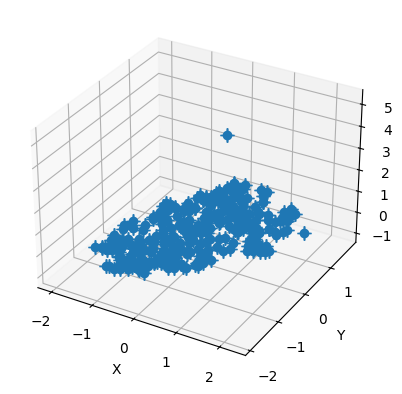

Number of sensors :  300
Parameters used :  {'kernel__k1__constant_value': 5.994842503189409, 'kernel__k2__length_scale': 0.46415888336127786}


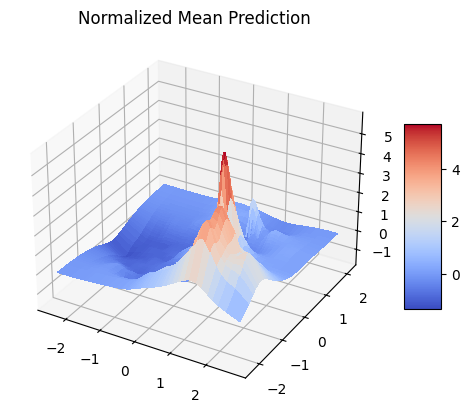

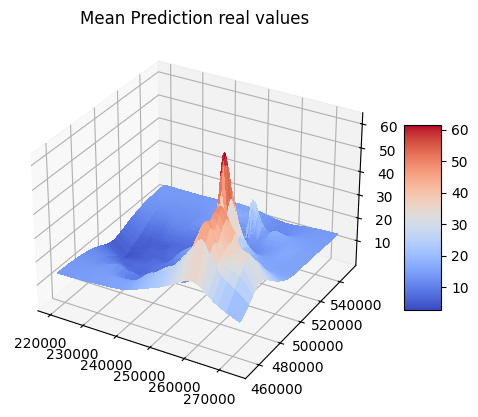

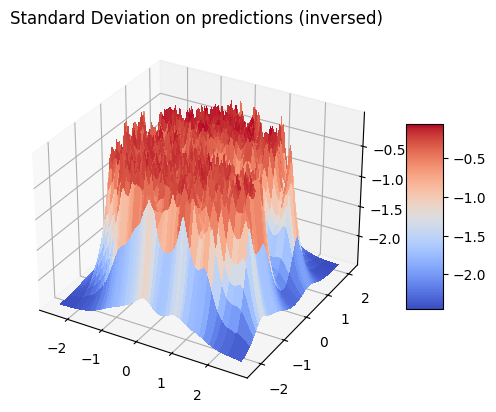

Relative error on mean_prediction :  1.7588998470796204  +-  0.06693178825903812
Relative error on mean_prediction :  2.079459942977125  +-  0.12713351319574295
Relative error on mean_prediction :  2.523260030318576  +-  0.12659196304684794
Relative error on mean_prediction :  3.0736402281897814  +-  0.22339127889094756


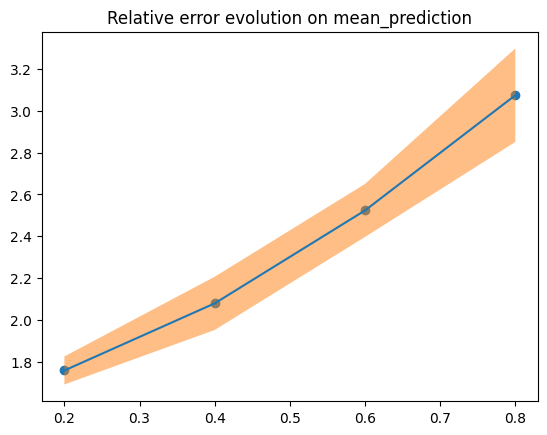

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/02/2023 12:00:00  -------


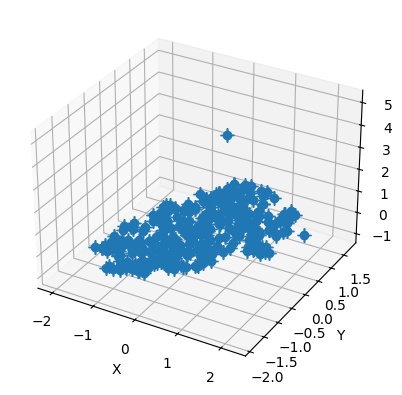

Number of sensors :  306
Parameters used :  {'kernel__k1__constant_value': 10.0, 'kernel__k2__length_scale': 0.46415888336127786}


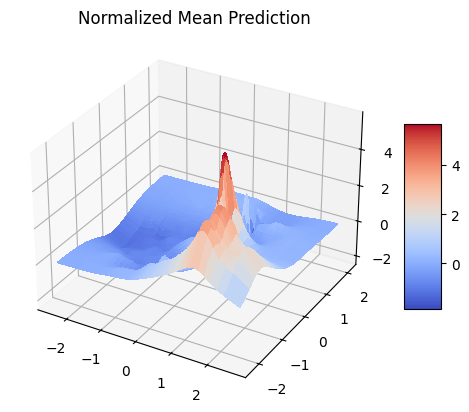

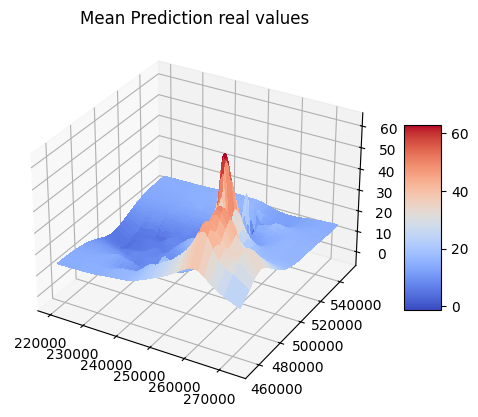

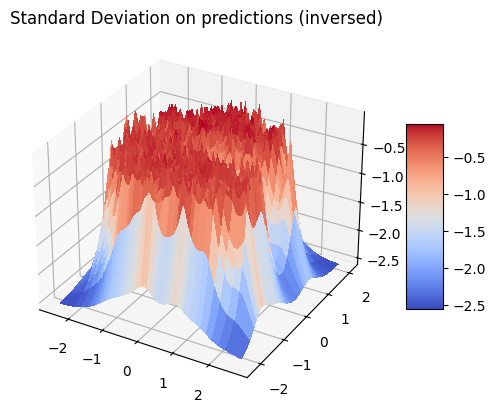

Relative error on mean_prediction :  1.5776994868133023  +-  0.06582269961762832
Relative error on mean_prediction :  1.8593597084320703  +-  0.07429648653574206
Relative error on mean_prediction :  2.037470835561793  +-  0.0996639432154276
Relative error on mean_prediction :  2.460819421799066  +-  0.13554038900046317


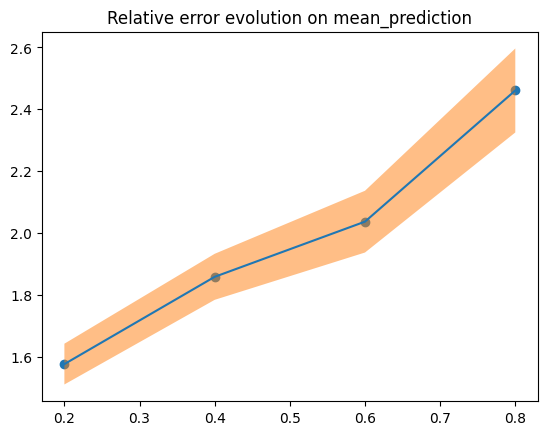

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/03/2023 12:00:00  -------


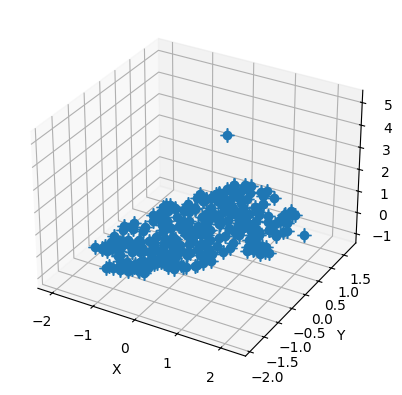

Number of sensors :  308
Parameters used :  {'kernel__k1__constant_value': 10.0, 'kernel__k2__length_scale': 0.46415888336127786}


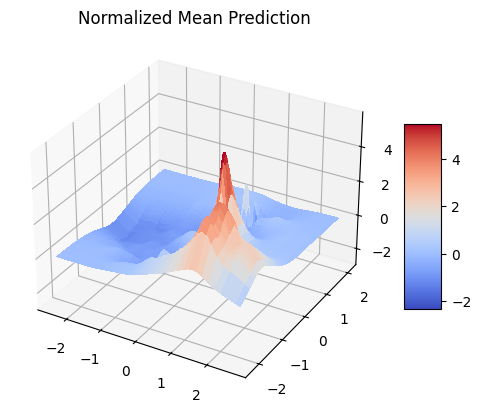

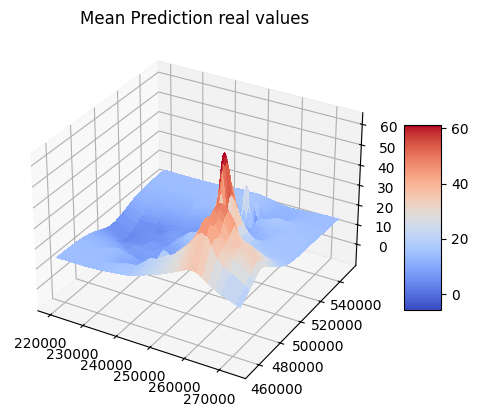

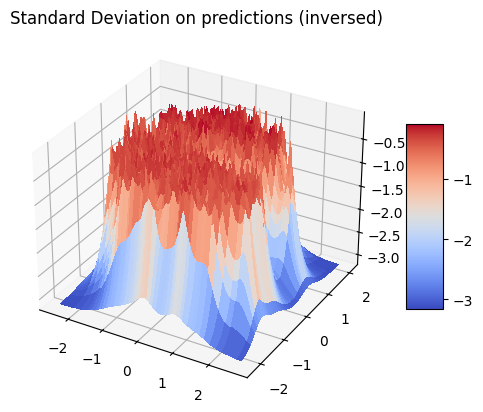

Relative error on mean_prediction :  3.41946449120276  +-  0.6504433552471163
Relative error on mean_prediction :  7.777319952409197  +-  3.089232728276679
Relative error on mean_prediction :  8.119396955062259  +-  3.672256484140455
Relative error on mean_prediction :  13.210673129168715  +-  3.8279663053644164


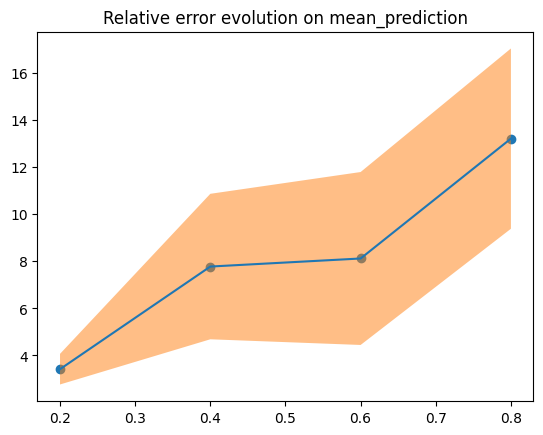

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/04/2023 12:00:00  -------


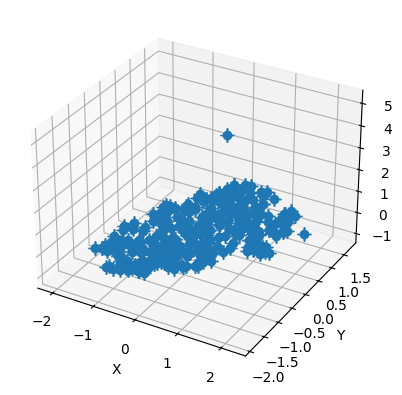

Number of sensors :  311
Parameters used :  {'kernel__k1__constant_value': 5.994842503189409, 'kernel__k2__length_scale': 0.46415888336127786}


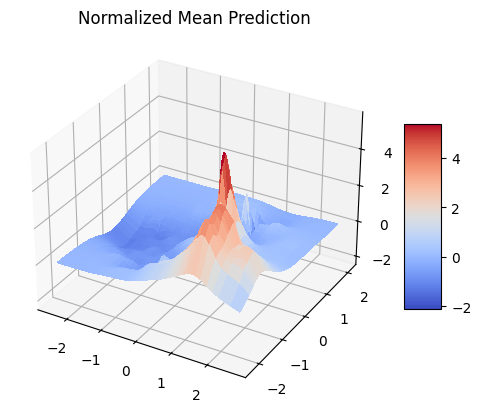

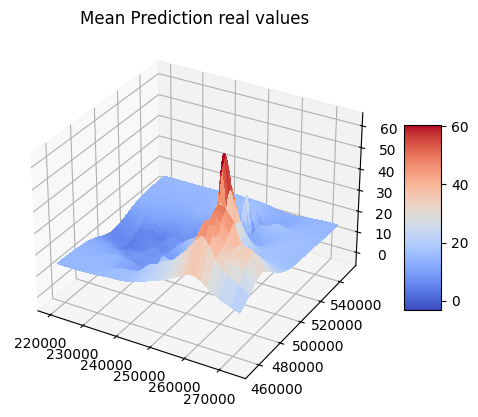

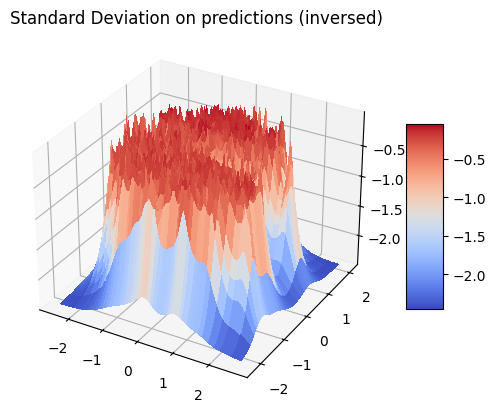

Relative error on mean_prediction :  1.578260782907889  +-  0.05565525670496507
Relative error on mean_prediction :  1.718427830381855  +-  0.14533489255151988
Relative error on mean_prediction :  1.83575521621719  +-  0.14044511885638067
Relative error on mean_prediction :  2.476953807573447  +-  0.159720414556332


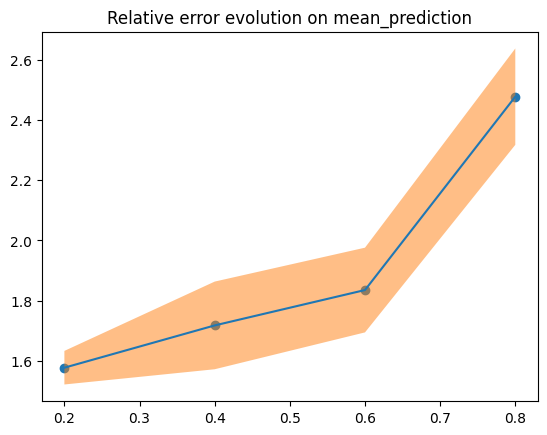

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/05/2023 12:00:00  -------


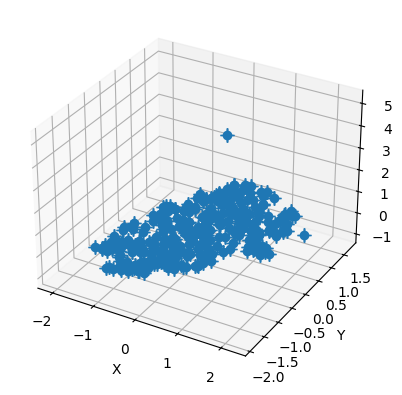

Number of sensors :  311
Parameters used :  {'kernel__k1__constant_value': 2.1544346900318834, 'kernel__k2__length_scale': 2.1544346900318834}


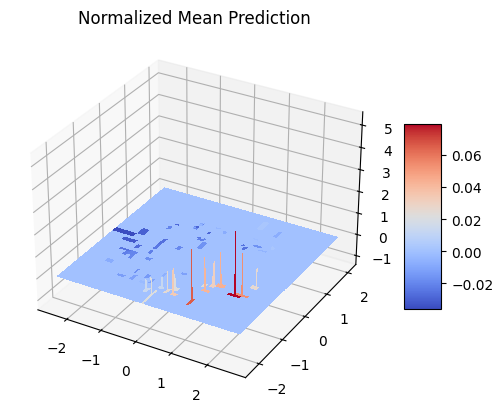

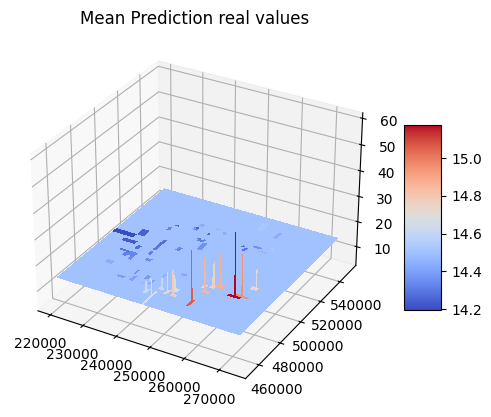

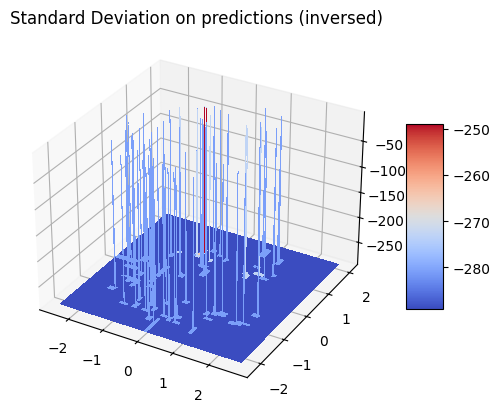

Relative error on mean_prediction :  524.2415674623993  +-  135.24116094581018
Relative error on mean_prediction :  523.7588627477437  +-  131.15551544796176
Relative error on mean_prediction :  484.1542739998097  +-  163.83480265555022
Relative error on mean_prediction :  633.5479529546483  +-  193.33004083125024


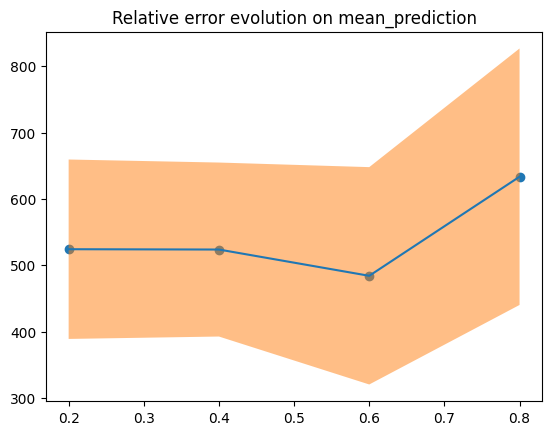

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/06/2023 12:00:00  -------


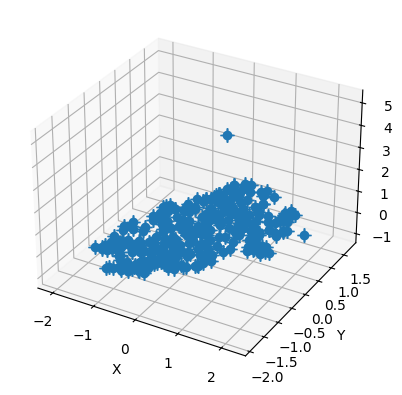

Number of sensors :  308
Parameters used :  {'kernel__k1__constant_value': 5.994842503189409, 'kernel__k2__length_scale': 0.46415888336127786}


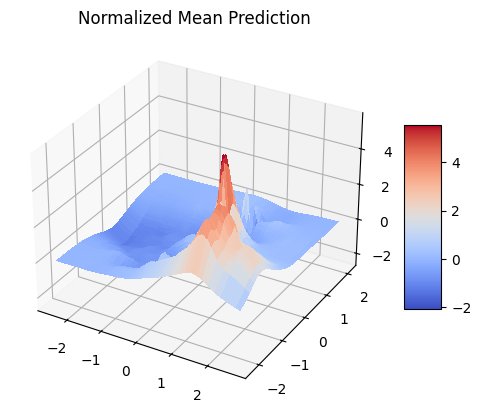

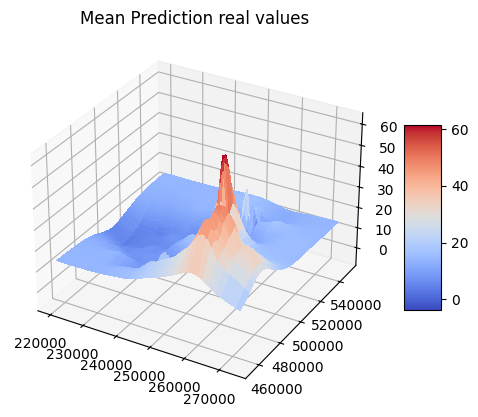

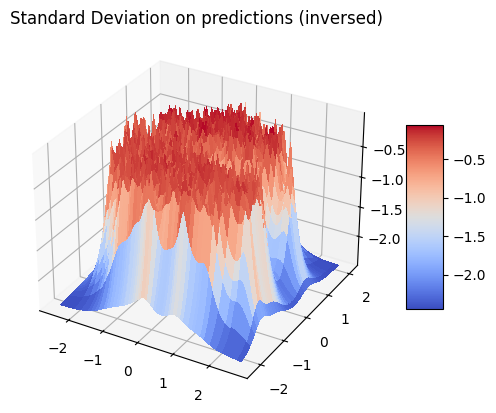

Relative error on mean_prediction :  2.0362259298179914  +-  0.16401715341435508
Relative error on mean_prediction :  2.156034877999423  +-  0.27198508264407795
Relative error on mean_prediction :  2.9045812857097957  +-  0.2521260808074901
Relative error on mean_prediction :  4.034951629201862  +-  0.4347307356828489


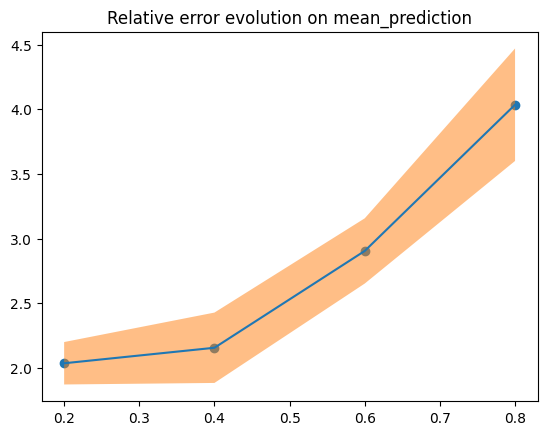

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/07/2023 12:00:00  -------


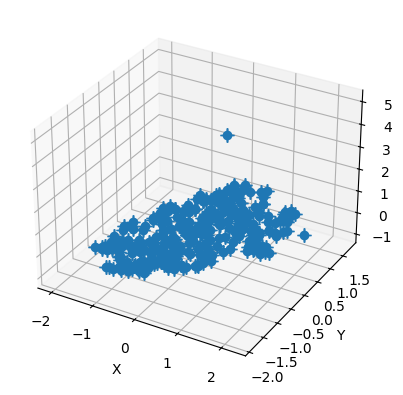

Number of sensors :  296
Parameters used :  {'kernel__k1__constant_value': 5.994842503189409, 'kernel__k2__length_scale': 0.16681005372000587}


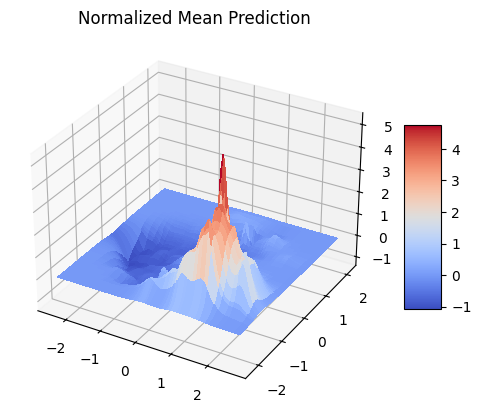

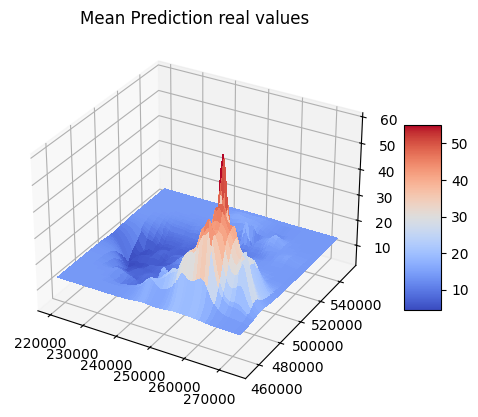

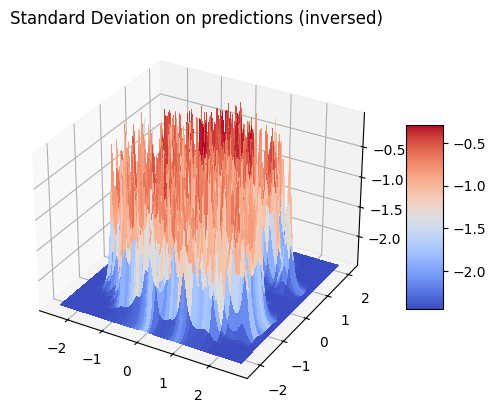

Relative error on mean_prediction :  1.8065814833268556  +-  0.33039850621328504
Relative error on mean_prediction :  2.7774032850957826  +-  0.6666557832980349
Relative error on mean_prediction :  3.669256544806883  +-  0.712641506018231
Relative error on mean_prediction :  6.438000432330511  +-  0.9148957020498241


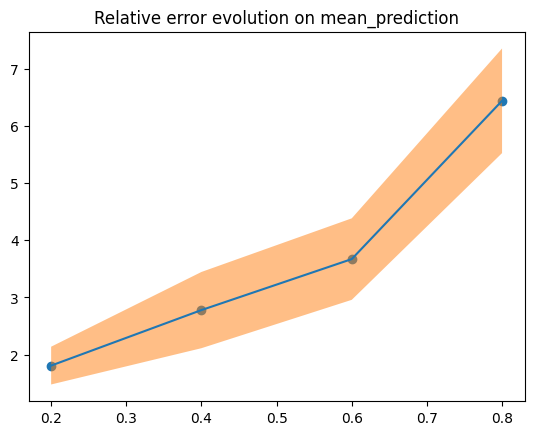

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/08/2023 12:00:00  -------


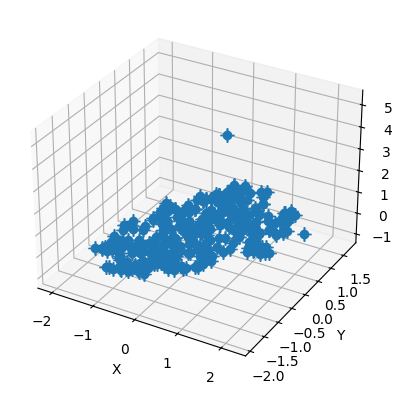

Number of sensors :  307
Parameters used :  {'kernel__k1__constant_value': 3.593813663804626, 'kernel__k2__length_scale': 0.46415888336127786}


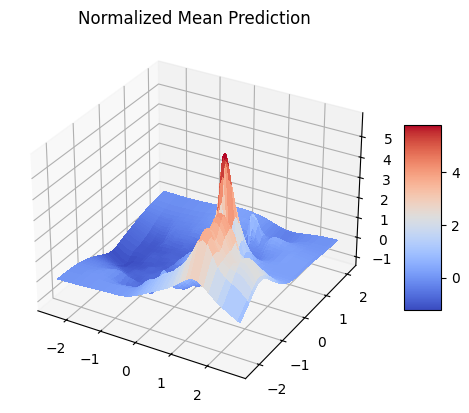

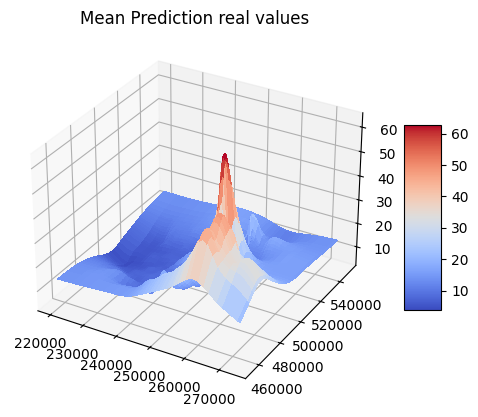

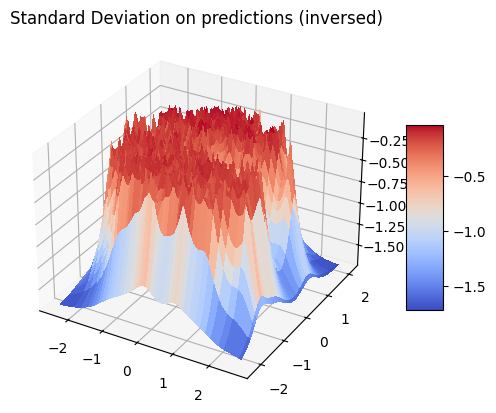

Relative error on mean_prediction :  1.8359587989161208  +-  0.10233455588021823
Relative error on mean_prediction :  2.504210377077768  +-  0.2131726522437245
Relative error on mean_prediction :  3.1478841245260982  +-  0.2899951332859958
Relative error on mean_prediction :  4.381187745488332  +-  0.4413216993951168


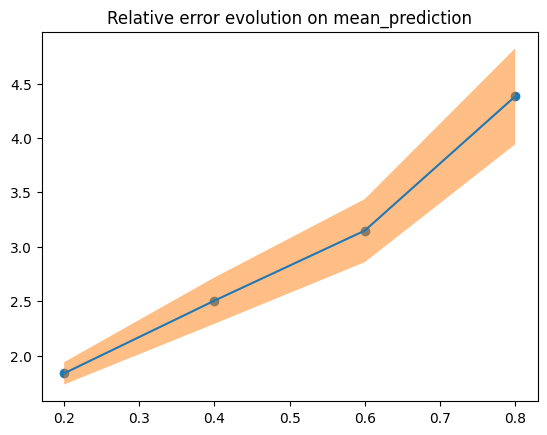

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/09/2023 12:00:00  -------


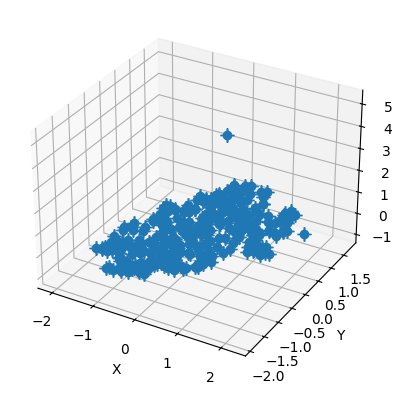

Number of sensors :  308
Parameters used :  {'kernel__k1__constant_value': 0.2782559402207124, 'kernel__k2__length_scale': 0.2782559402207124}


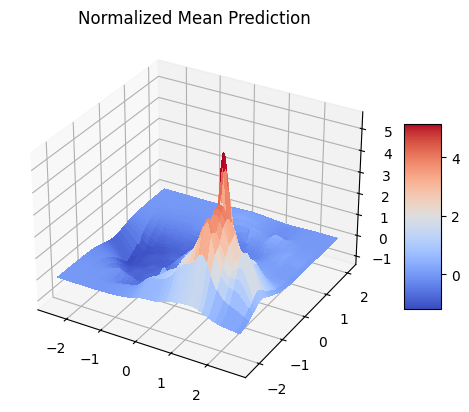

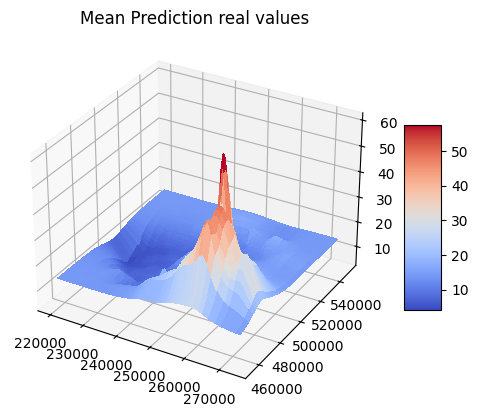

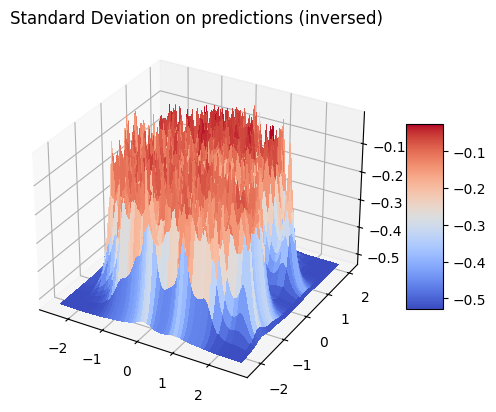

Relative error on mean_prediction :  1.4945500787518577  +-  0.07249521541225512
Relative error on mean_prediction :  1.50084164522612  +-  0.13380936960412693
Relative error on mean_prediction :  1.5614413646679037  +-  0.1562172879812158
Relative error on mean_prediction :  1.9861831071545069  +-  0.24698460485609375


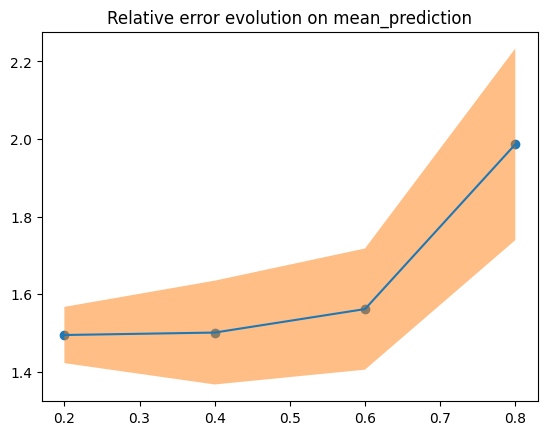

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/10/2023 12:00:00  -------


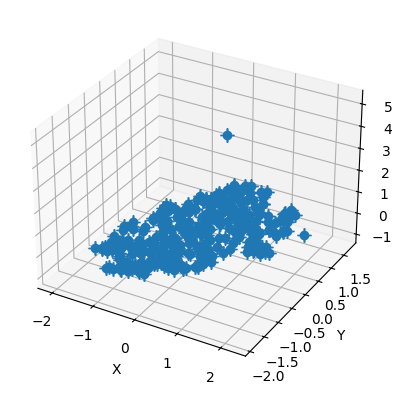

Number of sensors :  308
Parameters used :  {'kernel__k1__constant_value': 5.994842503189409, 'kernel__k2__length_scale': 0.2782559402207124}


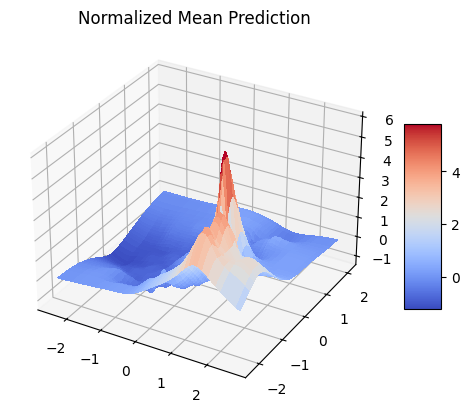

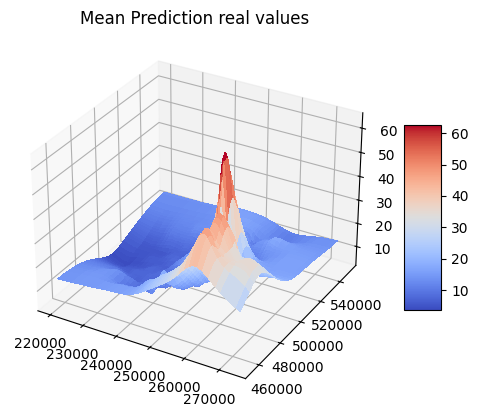

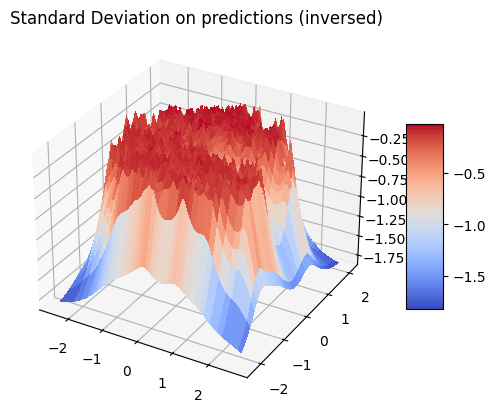

Relative error on mean_prediction :  1.4971726359516464  +-  0.05470436313003013
Relative error on mean_prediction :  1.7100099124115928  +-  0.04326066971897369
Relative error on mean_prediction :  1.8656627941645016  +-  0.09112249365964065
Relative error on mean_prediction :  2.476873973362437  +-  0.16073189606372962


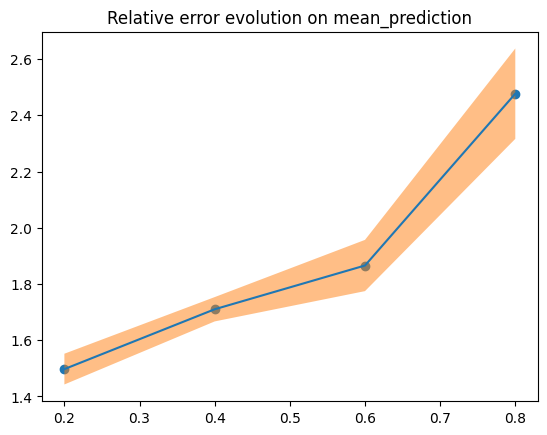

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/11/2023 12:00:00  -------


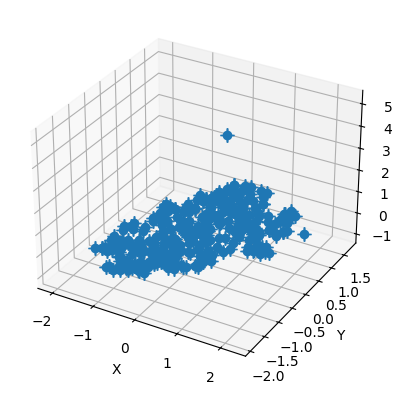

Number of sensors :  307
Parameters used :  {'kernel__k1__constant_value': 1.291549665014884, 'kernel__k2__length_scale': 0.16681005372000587}


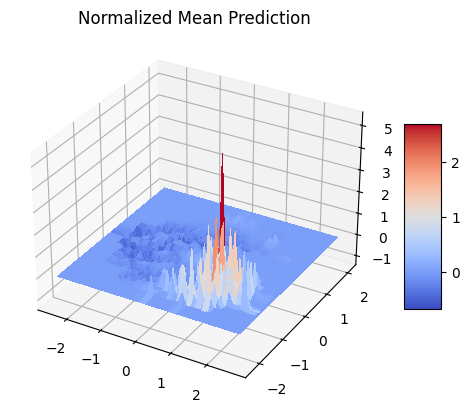

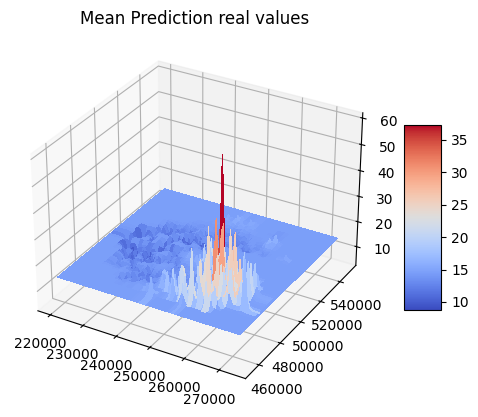

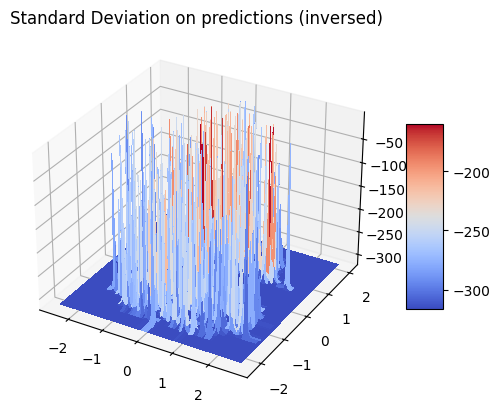

Relative error on mean_prediction :  55873.51533561748  +-  23213.26759531811
Relative error on mean_prediction :  57703.97245605371  +-  23092.04918321553
Relative error on mean_prediction :  86101.45740029994  +-  34013.751451356606
Relative error on mean_prediction :  147692.16229109422  +-  36915.3764932286


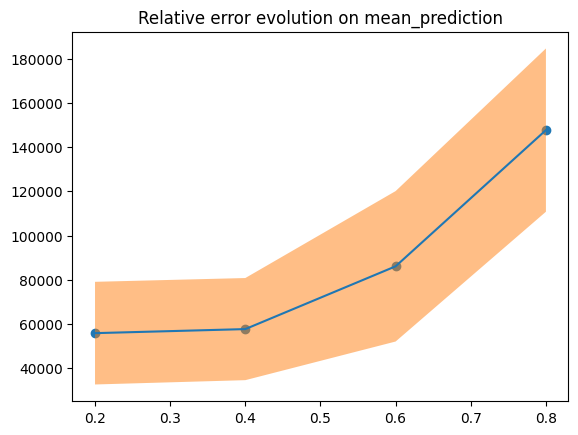

----- DATASET :  Vechtstromen  ----- TIMESTAMP :  01/12/2023 12:00:00  -------


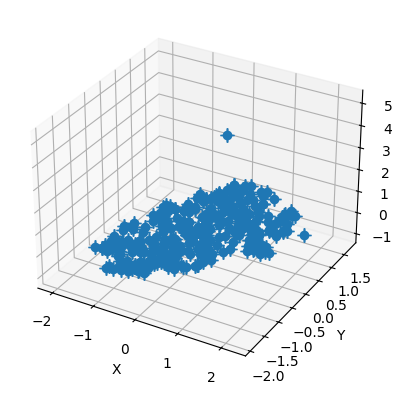

Number of sensors :  309
Parameters used :  {'kernel__k1__constant_value': 3.593813663804626, 'kernel__k2__length_scale': 0.2782559402207124}


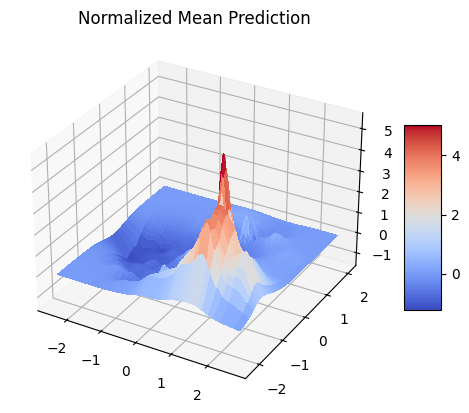

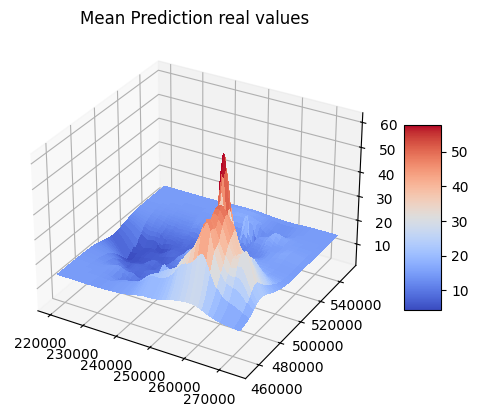

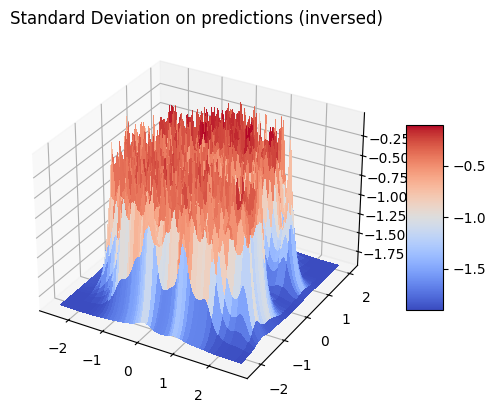

Relative error on mean_prediction :  1.607748951184558  +-  0.09277930693523428
Relative error on mean_prediction :  1.8399205881806966  +-  0.12756993237073
Relative error on mean_prediction :  2.071935951926506  +-  0.11154759117080792
Relative error on mean_prediction :  2.865320710318484  +-  0.2593206308707403


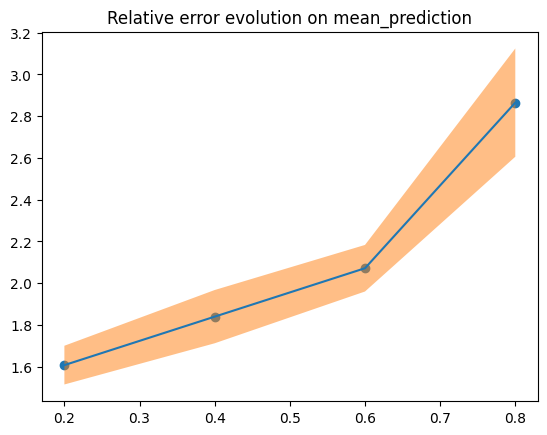

In [87]:
timestamps = create_monthly_timestamps(2023)
for timestamp in timestamps:
    full_GPR_test_and_training_computation()